In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
# LOCATION
from pyfrac.pseudodas.receiveroperators import cubePDoperator
from pyfrac.modelling.kirchhoff import Kirchhoff
from pyfrac.locationsolvers.imaging import *

from pyfrac.locationsolvers.localisationutils import get_max_locs

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage, wiggleplot
from pyfrac.visualisation.eventimages import locimage3d

In [3]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

# LOAD DATA, Rec, Models

In [4]:
seispath = '/home/birniece/Documents/Projects/MicroseismicModelling/SOFI_LargeRockBlock_Sandstone/expSetUp/outputs/su/'
nr = 9126

vy = read_seis(os.path.join(seispath,'expSetUp_p.txt'), nr)


In [5]:
vy.shape

(9126, 2000)

<Axes: title={'center': 'Seismic Recording'}, xlabel='Receiver #', ylabel='Time'>

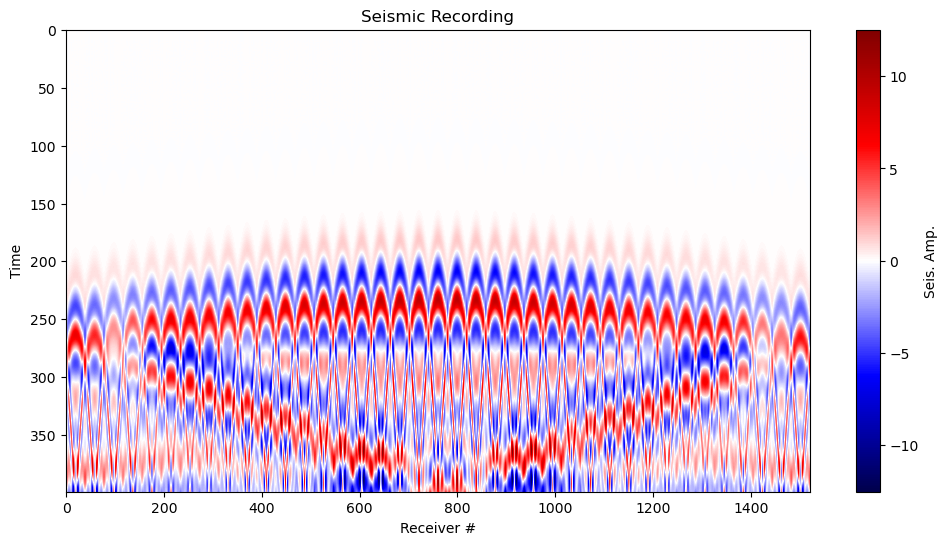

In [6]:
traceimage(vy[:39*39,:400], climQ=99.99)

In [7]:
# Load receivers
data_dir = '/home/birniece/Documents/data/ANPERC_Lab/LargeRockBlock/Sandstone'
recgeom = np.loadtxt(os.path.join(data_dir,'RecArray_fullcoverage.dat'))

fs_kHz = 100
fs = fs_kHz * 1000
rec_dt = 1/fs

rec_t = np.arange(0,vy.shape[1]*rec_dt - rec_dt, rec_dt)
nt = len(rec_t)

rec_t.shape

(1999,)

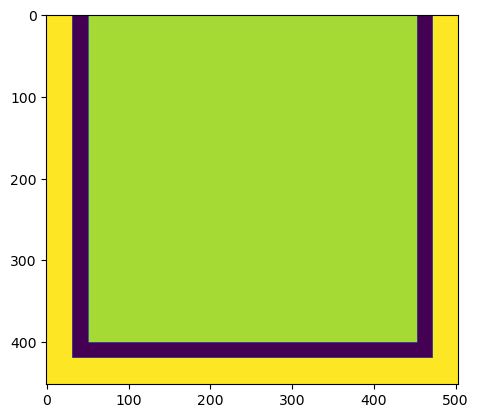

In [8]:
# Load velocity model
dx = dy = dz = 0.001 
nx,nz,ny = (504, 452, 504)
d_xzy = [dx, dz, dy]
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

# Subsurface properties
# load velocity model
inputsdir =  '/home/birniece/Documents/Projects/MicroseismicModelling/SOFI_LargeRockBlock_Sandstone/expSetUp/inputs'
vp_mod = np.fromfile(os.path.join(inputsdir,'expSetUp_wBounds_xyz_1mm.vp'), dtype=np.float32).reshape([nx,ny,nz])
plt.imshow(vp_mod[252,:,:].T)


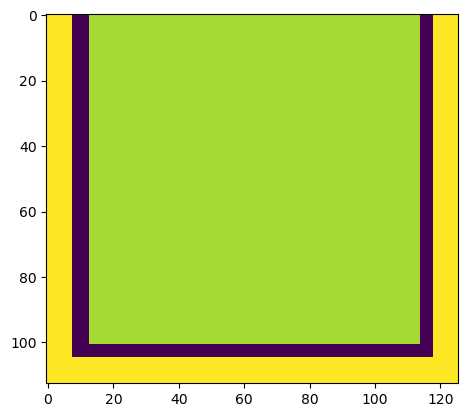

In [9]:
sbsmp = 4
vp_mod_subsamp = vp_mod[::sbsmp,::sbsmp,::sbsmp]
dx = dy = dz = 0.001 *sbsmp
nx,nz,ny = (int(504/sbsmp), int(452/sbsmp), int(504/sbsmp))

d_xzy = [dx, dz, dy]
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz

plt.imshow(vp_mod_subsamp[nx//2].T)

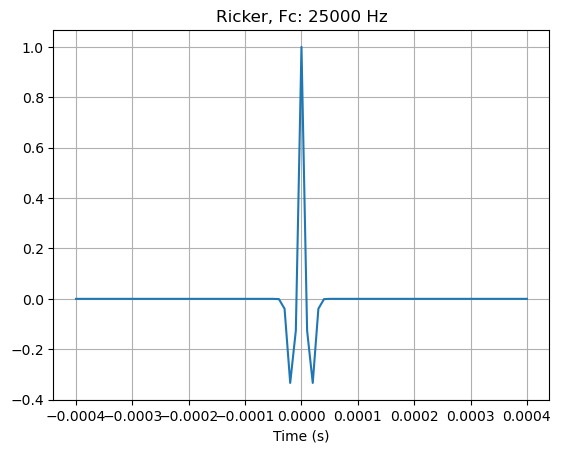

In [10]:
# Make wavelet
fwav = 25000  # WAVELET CENTRAL FREQUENCY
nt = 251  # TIME SAMPLES

wav, wavt, wavc = ricker(rec_t[:41], f0=fwav)
plt.plot(wavt, wav,)
plt.xlabel('Time (s)')
plt.title('Ricker, Fc: %i Hz'%fwav)
plt.grid()

# MAKE DATA

In [11]:
tshift = 7 # index of source ignition
vy = vy[:,tshift:500]
nt = vy.shape[1]

In [ ]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=rec_t[:nt], 
               srcs=recgeom.T[:, :1], 
               recs=recgeom.T, 
               vel=vp_mod_subsamp, 
               wav=wav, 
               wavcenter=wavc, 
               mode='eikonal', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

In [ ]:
sx, sy, sz = [nx//2, ny//2, nz//2]
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)

traceimage(frwddata[:50,:40], climQ=99.99)

In [ ]:
traceimage(vy[:50,:40], climQ=99.99)

In [ ]:
fig,axs = plt.subplots(1,2, figsize=[12,6])
traceimage(frwddata[:50,:60], climQ=99.99, ax=axs[0])
traceimage(vy[:50,:60], climQ=99.99, ax=axs[1])
axs[0].set_title('Frwd Model')
axs[1].set_title('eFD')

In [ ]:
migrated_synth, hc_synth = migration(Op, frwddata, (nx,ny,nz), nforhc=10)
migrated, hc = migration(Op, vy, (nx,ny,nz), nforhc=10)

print('Synth. Migration Hypo Center:',hc_synth)
print('eFD Migration Hypo Center:',hc)

In [ ]:
fig,axs = locimage3d(migrated_synth,20,20)
fig,axs = locimage3d(migrated,20,20)


# Inversion

In [ ]:
inv_synth, hc_synth = lsqr_migration(Op, frwddata, [nx,ny,nz], niter=100, nforhc=10, verbose=True)
inv, hc = lsqr_migration(Op, vy, [nx,ny,nz], niter=100, nforhc=10, verbose=True)

print('Synth. LSQR Hypo Center:',hc_synth)
print('eFD LSQR Hypo Center:',hc)

In [ ]:
fig,axs = locimage3d(inv_synth,20,20)
fig,axs = locimage3d(inv,20,20)

# X-Corr Imaging

In [ ]:
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging

In [ ]:
xc_synth, hc_synth, _, _ = xcorr_imaging(Op, frwddata, [nx,ny,nz], niter=100, xceps=8e-1, lr=1e-5, nforhc=10, verbose=True)
xc, hc, _, _ = xcorr_imaging(Op, vy, [nx,ny,nz], niter=100, xceps=8e-1, lr=1e-5, nforhc=10, verbose=True)

print('Synth. X-Corr Hypo Center:',hc_synth)
print('eFD X-Corr Hypo Center:',hc)

In [ ]:
fig,axs = locimage3d(xc_synth,20,20)
fig,axs = locimage3d(xc,20,20)